# Programming Exercise 3: Multi-class Classification and Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
from scipy.special import expit #Vectorized sigmoid function
from PIL import Image
from scipy import optimize

## Visualizing the data

In [2]:
data = scipy.io.loadmat('data/ex3data1.mat')
X, y = data['X'], data['y']
print('X.shape: ', X.shape)
print('y.shape: ', y.shape)

X.shape:  (5000, 400)
y.shape:  (5000, 1)


In [3]:
def transformData(line, imgWith=20, imgHeight=20):
    pixel = line.reshape(imgWith, imgHeight)
    return pixel.T

def displayData(imgX=X, rows=10, columns=10, pixelWith=20, pixelHeight=20):
    """展示mat数据图形"""
    displayPic = np.zeros([rows*pixelHeight, columns*pixelWith])
    imageIdx = random.sample(range(imgX.shape[0]), rows*columns)
    for row in range(rows):
        for column in range(columns):
            idx = imageIdx[row*columns+column]
            displayPic[row*pixelWith:(row+1)*pixelWith, column*pixelHeight:(column+1)*pixelHeight] = \
            transformData(imgX[idx])
    
    plt.figure(figsize = (5, 5))
    plt.imshow(displayPic, cmap=cm.Greys_r)

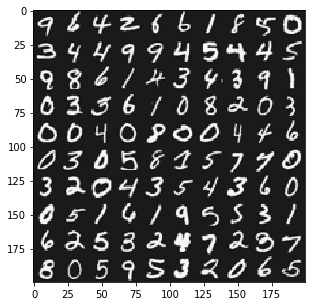

In [4]:
displayData()

## One-vs-all Classification

In [5]:
X = np.insert(X, 0, 1, axis=1)
initial_theta = np.zeros([X.shape[1], 1])

def h(theta, X):
    return expit(np.dot(X, theta))

def costFunction(theta, *args):
    X, y, lamb = args
    m = X.shape[0]
    h_y = h(theta, X) - y
    theta_1 = theta[1:]
    cost = -1./m * np.sum(np.dot(y.T, np.log(h(theta, X))) + np.dot((1-y).T, np.log(1-h(theta, X)))) + lamb/(2*m) * np.sum(np.dot(theta_1.T, theta_1))
    return cost
    
def costGradient(theta, *args):
    X, y, lamb = args
    m = X.shape[0]
    h_y = h(theta, X) - y
    theta_1 = theta[1:]
    grad = 1./m * np.dot(X.T, h_y)
    grad[1:] += lamb/m * theta_1
    return grad.T

def optimizeTheta(theta, X, y, lamb=0.):
    result = optimize.fmin_cg(costFunction, x0=theta, fprime=costGradient, args=(X, y, lamb), maxiter=50, disp=False, full_output=True)
    return result[0], result[1]

def buildTheta(X, y, lamb=0.):
    classes = len(np.unique(y).reshape(-1))
    initial_theta = np.zeros((X.shape[1], 1))
    theta = np.zeros([classes, X.shape[1]])
    for i in range(classes):
        iclass = i if i else 10 #class "10" corresponds to handwritten zero
        print('Optimizing for handwritten number %d...' % i)
        logic_y = np.array([1 if x == iclass else 0 for x in y])#.reshape((X.shape[0],1))
        itheta, imincost = optimizeTheta(initial_theta, X, logic_y, lamb)
        theta[i, :] = itheta
    print("Done!")
    return theta

In [6]:
optimize_theta = buildTheta(X, y, 0)

Optimizing for handwritten number 0...
Optimizing for handwritten number 1...
Optimizing for handwritten number 2...
Optimizing for handwritten number 3...
Optimizing for handwritten number 4...
Optimizing for handwritten number 5...
Optimizing for handwritten number 6...
Optimizing for handwritten number 7...
Optimizing for handwritten number 8...
Optimizing for handwritten number 9...
Done!


In [7]:
def predictOneVsAll(theta, x, y):
    """
    Function that computes a hypothesis for an individual image (row in X)
    and returns the predicted integer corresponding to the handwritten image
    """
    classes = np.unique(y)
    classes = np.where(classes==10, 0, classes)
    classes = np.sort(classes)
    predict_vals = np.zeros([len(classes), 1])
    for i in classes:
        predict_vals[i] = h(theta[i], x)
    return classes[np.argmax(np.array(predict_vals))]

In [8]:
n_correct, n_total = 0., 0.
incorrect_idx = []
for irow in range(X.shape[0]):
    n_total += 1
    real_y = 0 if y[irow]==10 else y[irow]
    if predictOneVsAll(optimize_theta, X[irow], y) == real_y: 
        n_correct += 1
    else: 
        incorrect_idx.append(irow)
print('Training set accuracy: %0.1f%%' % (100*(n_correct/n_total)))

Training set accuracy: 95.1%


In [18]:
X[incorrect_idx].shape
incorrect_X = np.delete(X[incorrect_idx], [0], axis=1)
incorrect_X.shape

(244, 400)

In [15]:
#Let's have a look at the ones we get wrong:
incorrect_arr = np.array(incorrect_idx).reshape(-1, 1)
displayData(imgX = incorrect_arr[:100])

ValueError: cannot reshape array of size 1 into shape (20,20)